In [1]:
%matplotlib inline
import numpy as np
import random
import math
import cv2
import matplotlib.pyplot as plt # matplotlibの描画系
import quaternion

In [2]:
#三次元回転行列生成に関する関数
    # 物体座標系の 1->2->3 軸で回転させる
def generateRotationMatrix(r):
    px = r[0]
    py = r[1]
    pz = r[2]
    
    Rx = np.array([[1, 0, 0],
            [0, np.cos(px), np.sin(px)],
            [0, -np.sin(px), np.cos(px)]])
    Ry = np.array([[np.cos(py), 0, -np.sin(py)],
            [0, 1, 0],
            [np.sin(py), 0, np.cos(py)]])
    Rz = np.array([[np.cos(pz), np.sin(pz), 0],
            [-np.sin(pz), np.cos(pz), 0],
            [0, 0, 1]])
    R = Rz.dot(Ry).dot(Rx)
    return R

def generateTransMatrix(t, r):
    R = generateRotationMatrix(r)
    transMatrix = np.eye(4,4)
    for y in range(0,3):
        for x in range(0,3):
            transMatrix[y, x] = R[y, x]
        transMatrix[y, 3] = t[y]
    return transMatrix

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 0.9828663   0.07378781 -0.16890589  0.00297877]
 [-0.11962664  0.95251911 -0.27999432  0.03648267]
 [ 0.14022592  0.29540262  0.94502592 -0.00477264]
 [ 0.          0.          0.          1.        ]]


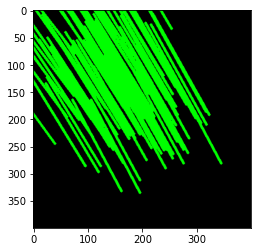

In [3]:
#観測データ生成
#位置姿勢の初期値（ランダム）
t = np.random.randn(3)*0.03
p = np.random.randn(3) * np.pi / 16
GM = generateTransMatrix(t, p)
print(GM)

#三次元点群
depth = 10
num_points = 100
PP = []
PG = []
for i in range(num_points):
    pt = np.random.randn(2)
    pt = [pt[0], pt[1], depth]    
    PP.append(pt)
    PG.append(pt)
PP = np.array(PP).transpose()
PG = np.array(PG).transpose()

#projection(to normal coord)
R = GM[0:3,0:3]
T = GM[0:3,3:4]
CPP = R @ PP + T
cpg = CPP[0:2,:] / CPP[2,:] 
cpp = CPP[0:2,:] / CPP[2,:] #with noise

pg = PG[0:2,:] / PG[2,:]

#debug flow
im_size = 400
f = 600
c = im_size / 2
image = np.zeros((im_size, im_size, 3))
for i in range(pg.shape[1]):
    p0 = cpg[:,i] * f + c
    p1 = pg[:,i] * f + c
    cv2.line(image,
         pt1=(int(p0[0]), int(p0[1])),
         pt2=(int(p1[0]), int(p1[1])),
         color=(0, 255, 0),
         thickness=3,
         lineType=cv2.LINE_4,
         shift=0)
    
plt.imshow(image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


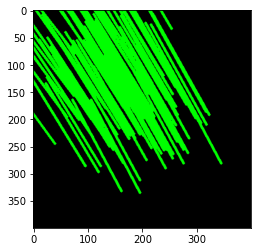

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


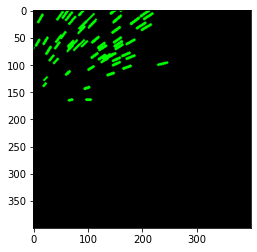

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


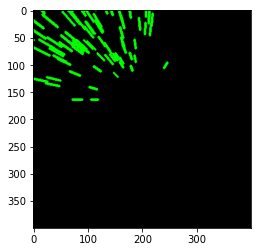

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


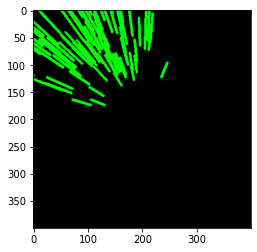

estimation
[[ 0.98208989  0.06970576 -0.17504445  0.08060697]
 [-0.12031769  0.94697034 -0.29794433  0.26703124]
 [ 0.14499347  0.31366905  0.93839683  8.49212282]
 [ 0.          0.          0.          1.        ]]
ground truth
[[ 0.9828663   0.07378781 -0.16890589  0.00297877]
 [-0.11962664  0.95251911 -0.27999432  0.03648267]
 [ 0.14022592  0.29540262  0.94502592 -0.00477264]
 [ 0.          0.          0.          1.        ]]


In [4]:
#位置姿勢推定
R = np.eye(3)
T = np.zeros((3,1))

debug_show = True

for i in range(4):
    image = np.zeros((im_size, im_size, 3))
    JtJ = np.zeros((6,6))
    JtE = np.zeros((6,1))
    E = np.zeros((2,1))
    for j in range(PP.shape[1]):
        projectPP = R @ PP[:,j:j+1] + T
        Xc = projectPP[0,0]
        Yc = projectPP[1,0]
        Zc = projectPP[2,0]
        xc = Xc / Zc
        yc = Yc / Zc
        A00 = 1 / Zc
        A02 = xc / Zc
        A03 = - xc * yc
        A04 = 1 + xc * xc
        A05 = - yc
        A11 = 1 / Zc
        A12 = yc / Zc
        A13 = -1 - yc * yc
        A14 = xc * yc
        A15 = xc
        A_ = np.array(
            [[A00, 0, A02, A03, A04, A05],
             [0, A11, A12, A13, A14, A15]]
        )
        E_ = cpg[:,j:j+1] - np.array([[xc],[yc]]) 
        JtJ += A_.transpose() @ A_
        JtE += A_.transpose() @ E_
        E += E_

        if(debug_show):
            p0 = np.array([xc,yc]) * f + c 
            p1 = cpg[:,j] * f + c
            cv2.line(image,
            pt1=(int(p0[0]), int(p0[1])),
            pt2=(int(p1[0]), int(p1[1])),
            color=(0, 255, 0),
            thickness=3,
            lineType=cv2.LINE_4,
            shift=0)

    ext = np.linalg.inv(JtJ) @ JtE
    T += ext[0:3,0:1]
    omega = ext[3:6,0]
    quat = quaternion.from_rotation_vector(omega)
    dR = quaternion.as_rotation_matrix(quat)
    R = dR @ R
    if(debug_show):
        plt.imshow(image)
        plt.show()

estM = np.eye(4)
estM[0:3,0:3] = R
estM[0:3,3:4] = T

print("estimation")
print(estM)
print("ground truth")
print(GM)